In [1]:
import sys
import datacube
import odc.geo.xr
import numpy as np
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

from dea_tools.datahandling import load_ard
from dea_tools.datahandling import mostcommon_crs
from dea_tools.dask import create_local_dask_cluster
from dea_tools.plotting import xr_animation
from dea_tools.coastal import tidal_tag

dc = datacube.Datacube(app='Animated tides')

%load_ext autoreload
%autoreload 2

In [15]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geopolygon = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4) 

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [16]:
bands = ["nbart_red", "nbart_green", "nbart_blue"]
# bands=['nbart_swir_1', 'nbart_nir', 'nbart_green']

# Configure local dask cluster
create_local_dask_cluster()

# Obtain native CRS
crs = mostcommon_crs(
    dc=dc, product="ga_ls5t_ard_3", query={"time": "1990", "geopolygon": geopolygon}
)

# Standard Landsat
query = {
    "geopolygon": geopolygon,
    "time": ("1987", "2024"),
    "measurements": bands,
    "resampling": {"fmask": "nearest", "oa_fmask": "nearest", "*": "cubic"},
    "output_crs": crs,
    "resolution": (-30, 30),
    "group_by": "solar_day",
    "dask_chunks": {"time": 1, "x": 2048, "y": 2048},
}

# # Landsat upscaled res
# query = {
#     'geopolygon': geopolygon,
#     'time': ('1986', '2020'),
#     'measurements': bands,
#     'resampling': {'fmask': 'nearest',
#                    'oa_fmask': 'nearest',
#                    '*': 'cubic'},
#     'output_crs': crs,
#     'resolution': (-15, 15),
#     'group_by': 'solar_day',
#     'dask_chunks': {'time': 1, 'x': 2000, 'y': 2000}
# }

# # Sentinel-2 10m
# crs = mostcommon_crs(dc=dc,
#                      product='s2a_ard_granule',
#                      query={'time': '2018',
#                             'geopolygon': geopolygon})

# query = {
#     'geopolygon': geopolygon,
#     'time': ('2016', '2020'),
#     'measurements': bands,
#     'resampling': {'fmask': 'nearest',
#                    'oa_fmask': 'nearest',
#                    '*': 'cubic'},
#     'output_crs': crs,
#     'resolution': (-10, 10),
#     'group_by': 'solar_day',
#     'dask_chunks': {'time': 1, 'x': 2000, 'y': 2000}
# }

ds_tides = load_ard(
    dc=dc,
    products=[
        "ga_ls5t_ard_3",
        "ga_ls7e_ard_3",
        "ga_ls8c_ard_3",
        "ga_ls9c_ard_3",
        "ga_s2am_ard_3",
        "ga_s2bm_ard_3",
        #                            's2a_ard_granule', 's2a_ard_granule'
    ],
    min_gooddata=0.90,
    ls7_slc_off=False,
    # mask_pixel_quality=False,
    **query
)

# Load data into memory
ds_tides = ds_tides.compute()
ds_tides

/env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36955 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/36955/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/36955/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34917,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/36955/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:40845,Total threads: 31
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/34663/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:34685,


/env/lib/python3.10/site-packages/dea_tools/datahandling.py:276: UserWarning: You have selected a combination of Landsat and Sentinel-2 products. This can produce unexpected results as these products use the same names for different spectral bands (e.g. Landsat and Sentinel-2's 'nbart_swir_2'); use with caution.
  warnings.warn(


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
    ga_ls9c_ard_3
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask


/env/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 14.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 714 out of 1899 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Returning 714 time steps as a dask array


<xarray.Dataset> Size: 9GB
Dimensions:      (time: 714, y: 835, x: 1307)
Coordinates:
  * time         (time) datetime64[ns] 6kB 1987-05-27T00:17:12.734890 ... 202...
  * y            (y) float64 7kB -1.741e+06 -1.742e+06 ... -1.766e+06 -1.767e+06
  * x            (x) float64 10kB 6.708e+05 6.708e+05 ... 7.1e+05 7.1e+05
    spatial_ref  int32 4B 32653
Data variables:
    nbart_red    (time, y, x) float32 3GB 2.182e+03 2.234e+03 ... 1.379e+03
    nbart_green  (time, y, x) float32 3GB 1.742e+03 1.765e+03 ... 1.265e+03
    nbart_blue   (time, y, x) float32 3GB 1.101e+03 1.12e+03 ... 789.0 857.0
Attributes:
    crs:           epsg:32653
    grid_mapping:  spatial_ref

## Tidal modelling

In [17]:
ds_tides = tidal_tag(ds_tides, ebb_flow=True, swap_dims=True)

Setting tide modelling location from dataset centroid: 136.78, -15.86
Modelling tides using FES2014
Modelling tidal phase (e.g. ebb or flow)
Modelling tides using FES2014


In [18]:
# Extract ebb and flow stages as different datasets
filtered_flow = ds_tides.where(ds_tides.ebb_flow == 'Flow', drop = True)
filtered_ebb = ds_tides.where(ds_tides.ebb_flow == 'Ebb', drop = True)

In [19]:
# Sort flow by increasing tide height, and ebb by decreasing
filtered_flow = filtered_flow.sortby('tide_m')
filtered_ebb = filtered_ebb.sortby('tide_m', ascending=False)

In [20]:
window = 50

# Extract end of ebb and start of flow
end_of_flow = filtered_flow.isel(tide_m=slice(-(window // 2)-5, -1))
start_of_ebb = filtered_ebb.isel(tide_m=slice(0, 5+(window // 2)))

# Combine into a single array and take rolling median
import xarray as xr
ds_concat = xr.concat([end_of_flow, filtered_ebb, 
                       filtered_flow, start_of_ebb], dim='tide_m')

ds_rolling = (ds_concat
              .drop_vars('ebb_flow')
              .rolling(tide_m=window, center=True, min_periods=1)
              .median())

# Restore ebb-flow data and drop out buffered ends of tide series
ds_rolling['ebb_flow'] = ds_concat['ebb_flow']
ds_rolling = ds_rolling.isel(tide_m=slice(5+(window // 2), -(window // 2)-5))

# Add random noise to tide heights to avoid indexing issues
ds_rolling['tide_m'] = ds_rolling['tide_m'] + (np.random.random(len(ds_rolling.tide_m)) - 0.5) / 100

In [21]:
# ndwi = (ds_rolling.nbar_green - ds_rolling.nbar_nir) / (ds_rolling.nbar_green + ds_rolling.nbar_nir)
# ndwi_rescaled = (10-(ndwi+1)/2)/10

In [22]:
# ds_rolling[['nbar_red', 'nbar_green', 'nbar_blue']] = ds_rolling[['nbar_red', 'nbar_green', 'nbar_blue']] * ndwi_rescaled

In [23]:
# test = ds_rolling[['nbar_red', 'nbar_green', 'nbar_blue']] * ndwi_rescaled

In [24]:
# Extract ebb and flow stages as different datasets
filtered_flow = ds_rolling.where(ds_rolling.ebb_flow == 'Flow', drop = True)
filtered_ebb = ds_rolling.where(ds_rolling.ebb_flow == 'Ebb', drop = True)

# Interpolate even number of frames for ebb and flow tides
import numpy as np
int_bins = np.linspace(filtered_flow.tide_m.min(), 
                       filtered_flow.tide_m.max(), 75)
ds_interp_flow = filtered_flow.interp(tide_m=int_bins)

int_bins = np.linspace(filtered_ebb.tide_m.max(), 
                       filtered_ebb.tide_m.min(), 75)
ds_interp_ebb = filtered_ebb.interp(tide_m=int_bins)

# Finally combine all frames
ds_interp = xr.concat([ds_interp_ebb, ds_interp_flow], dim='tide_m')

In [25]:
ebb_flow_text = len(ds_interp_ebb.tide_m) * ['Ebb tide'] + len(ds_interp_flow.tide_m) * ['Flow tide']
tide_text = [f'{a}\n{b:0.2f} m' for a, b in zip(ebb_flow_text, ds_interp.tide_m.values)]

Exporting animation to animated_tides_gulf.mp4


  0%|          | 0/150 (0.0 seconds remaining at ? frames/s)

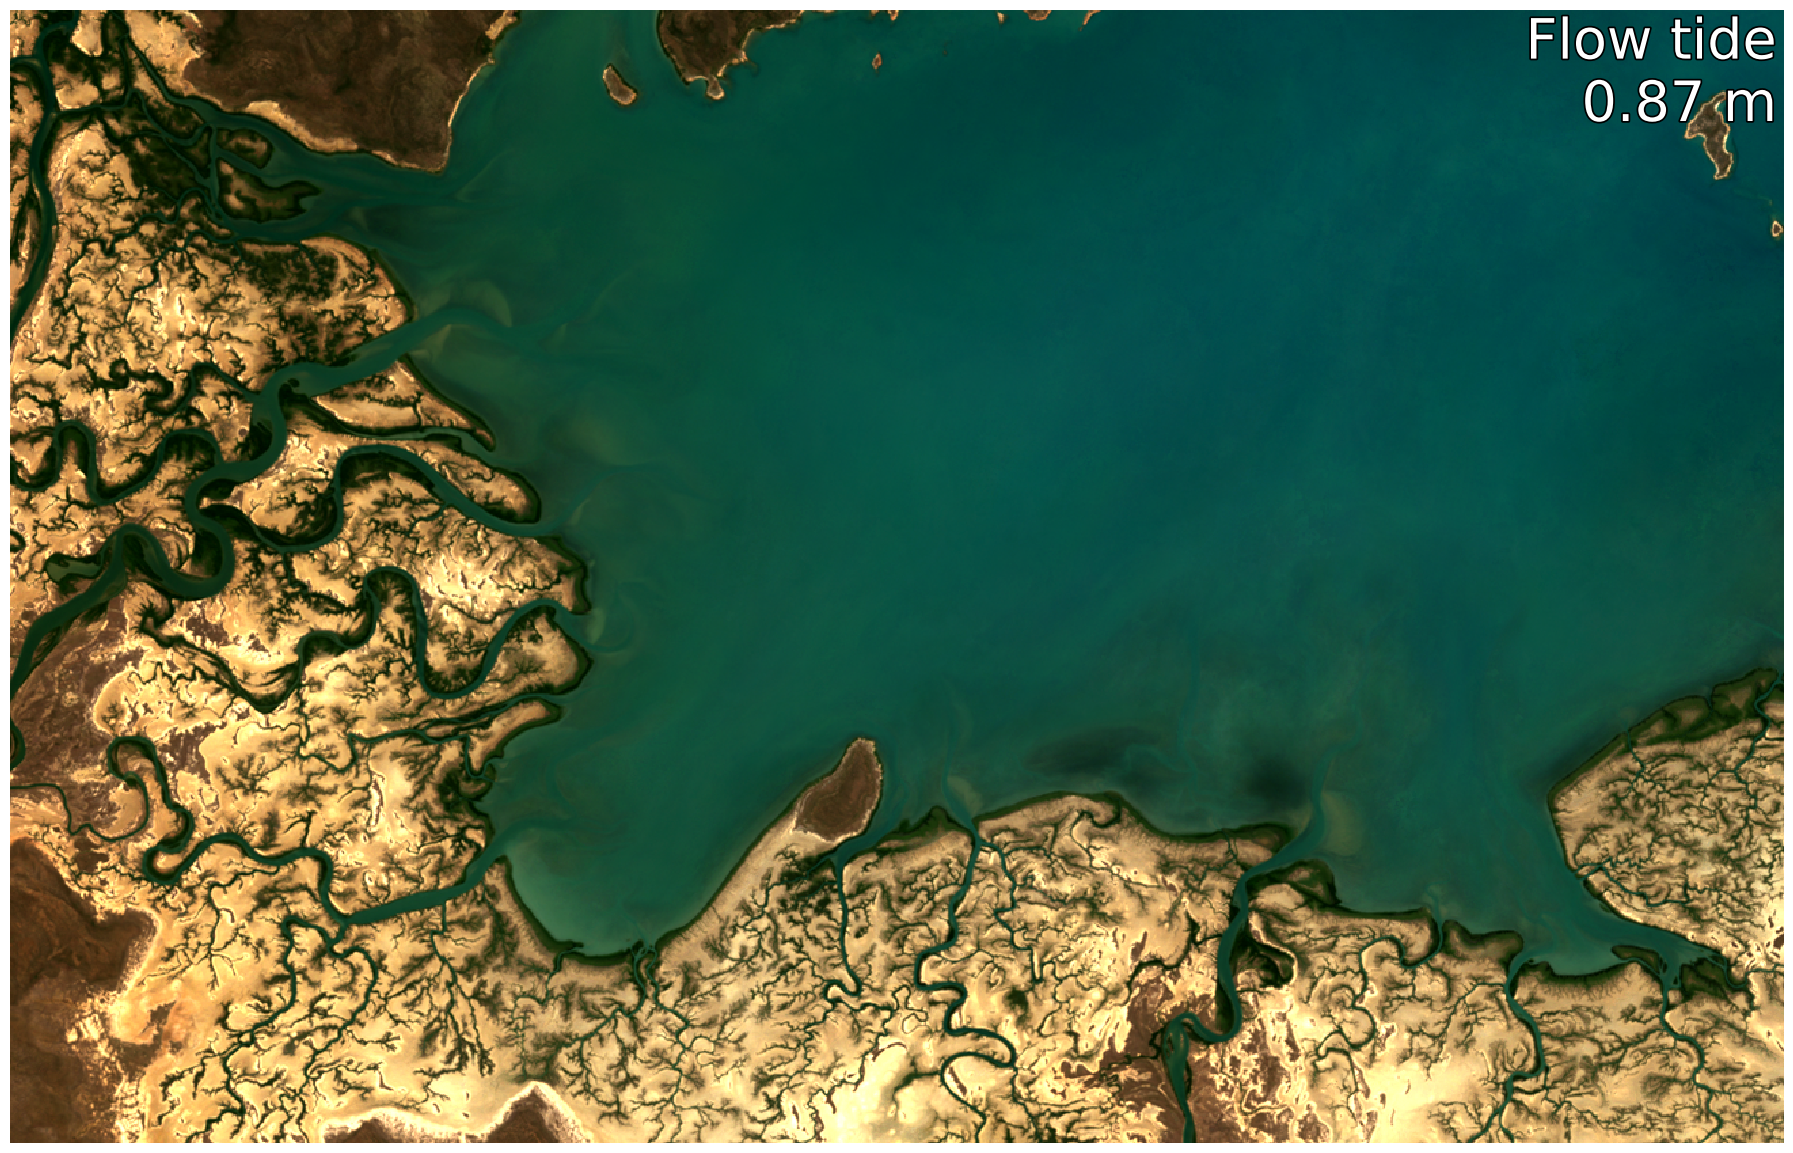

In [26]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity, adjust_sigmoid

funcs_list = [
#               lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
              lambda x: x**0.8,
              rescale_intensity,
#               hue_sat_val,
              lambda x: unsharp_mask(x, radius=50, amount=0.4),
              lambda x: unsharp_mask(x, radius=5, amount=0.2),
              # lambda x: adjust_sigmoid(image=x, cutoff=0.5, gain=0.5),
             ]
funcs_list = None

xr_animation(ds=ds_interp.rename({'tide_m': 'time'}),
             output_path='animated_tides_gulf.mp4',
             bands=bands[0:3],
             interval=30,
             width_pixels=1280,
             percentile_stretch=(0.01, 0.99),
             image_proc_funcs=funcs_list,
             show_date=False,
             show_text=tide_text,
             annotation_kwargs={'fontsize': 40},
             # limit=4
            ) 

In [ ]:
!ffprobe animated_tides2.mp4

In [ ]:
import gc
gc.collect()

In [ ]:
# Create copy and set time to time
data_tide = data.copy(deep=True)
data_tide['time'] = data_tide['tide_heights']
data_tide.rename({'time': 'tide'}, inplace=True)

# Extract ebb and flow stages as different datasets
filtered_flow = data_tide.where(data_tide.tide_phase == 'Flow', drop = True)
filtered_ebb = data_tide.where(data_tide.tide_phase == 'Ebb', drop = True)

# Sort flow by increasing tide height, and ebb by decreasing
filtered_flow = filtered_flow.sortby('tide')
filtered_ebb = filtered_ebb.sortby('tide', ascending=False)

# Drop categorical labels to allow rolling window
print(filtered_flow)
print(filtered_ebb)


In [ ]:
ds_rolling = ds_ls.rolling(time=40, center=True, min_periods=1).median()
median_array = np.transpose(ds_rolling[bands]
                            .median(dim='time')
                            .to_array().values, 
                            axes=(1, 2, 0))
print(ds_rolling)

## DEA CoastLines data

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib

# Get bounding box of data
xmin, ymin, xmax, ymax = ds_ls.geobox.geographic_extent.boundingbox

# Set up WFS requests for annual coastlines & rates of change statistics
deacl_coastlines_wfs = 'https://nonprod.geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       'service=WFS&version=1.1.0&request=GetFeature&' \
                       'typeName=dea:coastlines&maxFeatures=1000&' \
                      f'bbox={ymin},{xmin},{ymax},{xmax},urn:ogc:def:crs:EPSG:4326'

# Load data from WFS and set CRS
deacl_gdf = gpd.read_file(deacl_coastlines_wfs)
deacl_gdf.crs = 'EPSG:3577'

# Clip to extent of satellite data
bbox = gpd.GeoDataFrame(geometry=[ds_ls.geobox.extent.geom],
                        crs=ds_ls.geobox.crs)  
deacl_gdf = gpd.overlay(deacl_gdf, bbox.to_crs(deacl_gdf.crs))
deacl_gdf = deacl_gdf.dissolve('year')

# Apply colours
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(deacl_gdf.index))
cmap = matplotlib.cm.get_cmap('inferno')
rgba = cmap(norm(deacl_gdf.reset_index().index))
deacl_gdf['color'] = list(rgba)
deacl_gdf['start_time'] = (pd.to_datetime(deacl_gdf.index) + 
                           pd.DateOffset(months=5))

# Remove a year
# deacl_gdf = deacl_gdf.drop('1993')

deacl_gdf.plot()

## Run animation

In [ ]:
from skimage.color import rgb2hsv, hsv2rgb

def hue_sat_val(rgb_array,
                hue_mult=1, 
                sat_mult=0.8, 
                val_mult=1):   
    
    # Convert to HSV and multiply bands
    hsv_array = rgb2hsv(rgb_array)
    hsv_array[:, :, 0] = hsv_array[:, :, 0] * hue_mult
    hsv_array[:, :, 1] = hsv_array[:, :, 1] * sat_mult
    hsv_array[:, :, 2] = hsv_array[:, :, 2] * val_mult
    
    # Convert back to RGB
    return hsv2rgb(hsv_array.clip(0, 1))



In [ ]:
import geopandas as gpd

# Specify bounding box
ymax, xmin = -33.6507, 115.2790
ymin, xmax = -33.6585, 115.3013

# Set up WFS requests for annual coastlines & rates of change statistics
deacl_coastlines_wfs = 'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       'service=WFS&version=1.1.0&request=GetFeature&' \
                       'typeName=dea:coastlines&srsName=EPSG%3A3577&' \
                       f'maxFeatures=1000&bbox={ymin},{xmin},{ymax},{xmax}'
deacl_statistics_wfs = 'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       'service=WFS&version=1.1.0&request=GetFeature&' \
                       'typeName=dea:coastlines_statistics&' \
                       'srsName=EPSG%3A3577&maxFeatures=1000&' \
                       f'bbox={ymin},{xmin},{ymax},{xmax}'

# Load DEA CoastLines data from WFS using geopandas
deacl_coastlines_gdf = gpd.read_file(deacl_coastlines_wfs)
deacl_statistics_gdf = gpd.read_file(deacl_statistics_wfs)

# Ensure CRSs are set correctly
deacl_coastlines_gdf.crs = 'EPSG:3577'
deacl_statistics_gdf.crs = 'EPSG:3577'